In [1]:
import numpy as np
import tcbench as tcb
import pickle
from functions import (extract_results_limits_per_class,
                       extract_results_limits_per_class_splits_avg,
                       plot_results_limits_per_class)

In [2]:
vectors_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_labels.npy')
vectors_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_labels.npy')

In [3]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [4]:
within_class_file = "/home/ev357/rds/hpc-work/baseline_min_within.pkl"
between_class_file = "/home/ev357/rds/hpc-work/baseline_min_between.pkl"

with open(within_class_file, 'rb') as f:
    min_within_baseline = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_baseline = pickle.load(f)

In [5]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_min_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_min_between.npy"

with open(within_class_file, 'rb') as f:
    min_within_embeddings = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_embeddings = pickle.load(f)

In [6]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_min_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_min_between.npy"

with open(within_class_file, 'rb') as f:
    min_within_embeddings_cosine = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_embeddings_cosine = pickle.load(f)

In [7]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_max_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_max_between.npy"

with open(within_class_file, 'rb') as f:
    max_within_embeddings_cosine_similarity = pickle.load(f)
with open(between_class_file, 'rb') as f:
    max_between_embeddings_cosine_similarity = pickle.load(f)

In [8]:
def calculate_statistics_per_class(distances, percentiles=range(1, 101)):
    stats_per_class = {}

    for label, distance_array in distances.items():
        flattened_distances = distance_array.flatten()

        stats = {
            "min": np.min(flattened_distances),
            "avg": np.mean(flattened_distances),
            "max": np.max(flattened_distances),
            "stddev": np.std(flattened_distances),
            "variance": np.var(flattened_distances),
            "percentiles": {p: np.percentile(flattened_distances, p) for p in percentiles},
        }

        stats_per_class[label] = stats

    return stats_per_class

In [9]:
stats_min_within_baseline = calculate_statistics_per_class(min_within_baseline)
stats_min_between_baseline = calculate_statistics_per_class(min_between_baseline)

In [10]:
stats_min_within_embeddings = calculate_statistics_per_class(min_within_embeddings)
stats_min_between_embeddings = calculate_statistics_per_class(min_between_embeddings)

In [11]:
stats_min_within_embeddings_cosine = calculate_statistics_per_class(min_within_embeddings_cosine)
stats_min_between_embeddings_cosine = calculate_statistics_per_class(min_between_embeddings_cosine)

In [12]:
stats_max_within_embeddings_cosine_similarity = calculate_statistics_per_class(max_within_embeddings_cosine_similarity)
stats_max_between_embeddings_cosine_similarity = calculate_statistics_per_class(max_between_embeddings_cosine_similarity)

In [13]:
samples = [10, 100, 1000]
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

class_limits_baseline = {
    p: {label: stats_min_within_baseline[label]["percentiles"][p] for label in stats_min_within_baseline.keys()}
    for p in percentiles
}

class_limits_embeddings = {
    p: {label: stats_min_within_embeddings[label]["percentiles"][p] for label in stats_min_within_embeddings.keys()}
    for p in percentiles
}

class_limits_embeddings_cosine = {
    p: {label: 1 - stats_min_within_embeddings_cosine[label]["percentiles"][p] for label in stats_min_within_embeddings_cosine.keys()}
    for p in percentiles
}

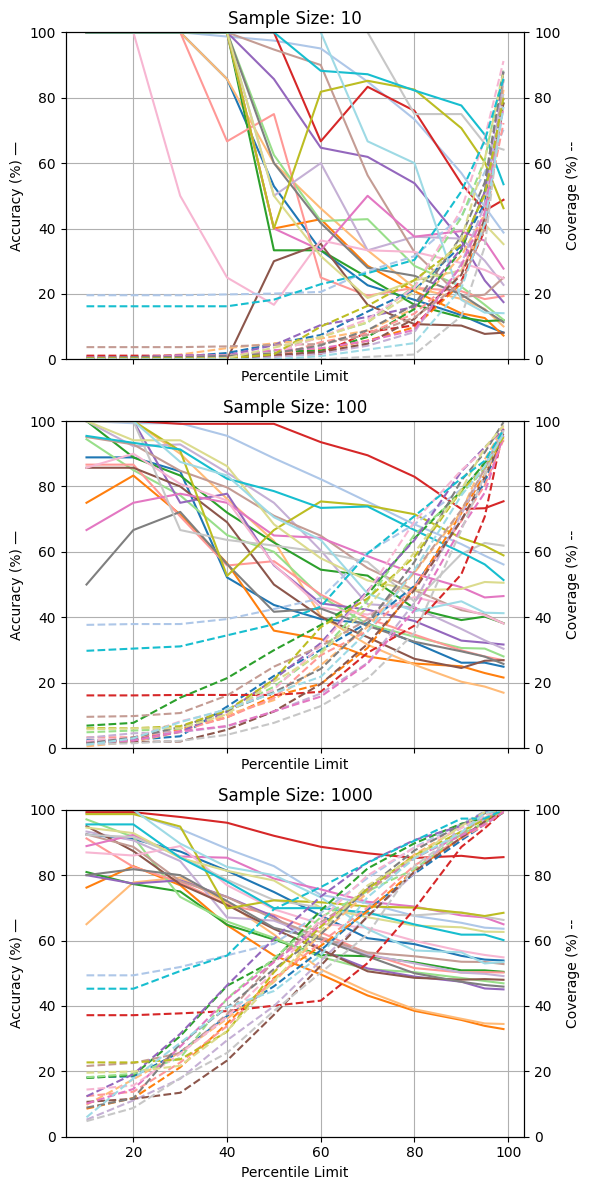

In [14]:
coverage_results_baseline_limits_per_class, accuracy_results_baseline_limits_per_class = extract_results_limits_per_class(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, class_limits_baseline)
plot_results_limits_per_class(coverage_results_baseline_limits_per_class, accuracy_results_baseline_limits_per_class, samples, percentiles)

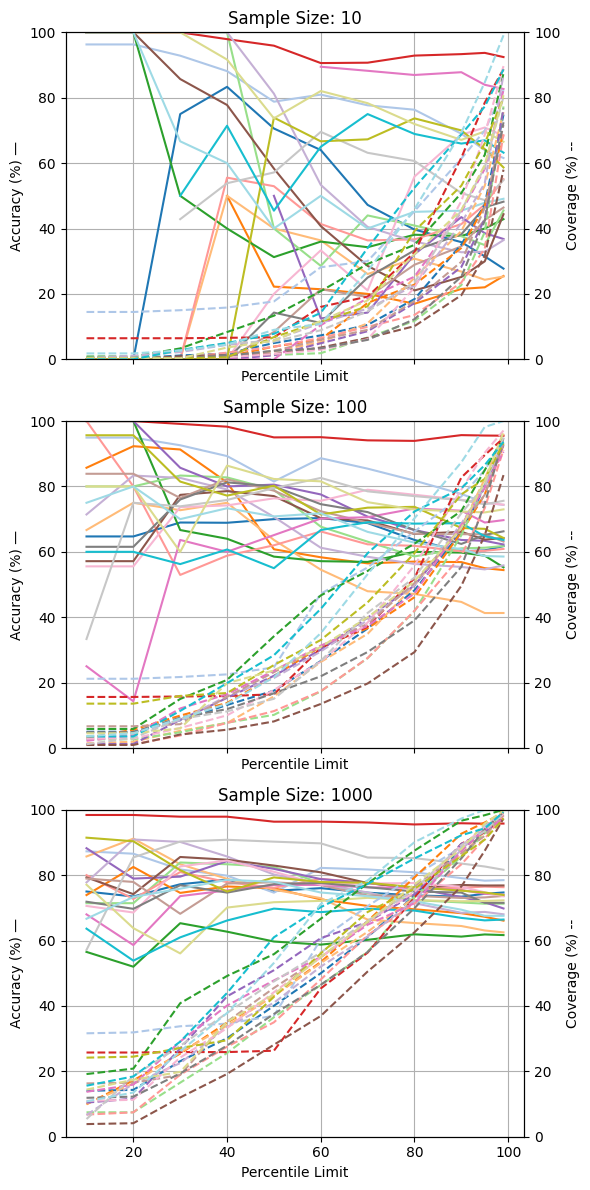

In [15]:
coverage_results_embeddings_limits_per_class, accuracy_results_embeddings_limits_per_class = extract_results_limits_per_class(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, class_limits_embeddings)
plot_results_limits_per_class(coverage_results_embeddings_limits_per_class, accuracy_results_embeddings_limits_per_class, samples, percentiles)

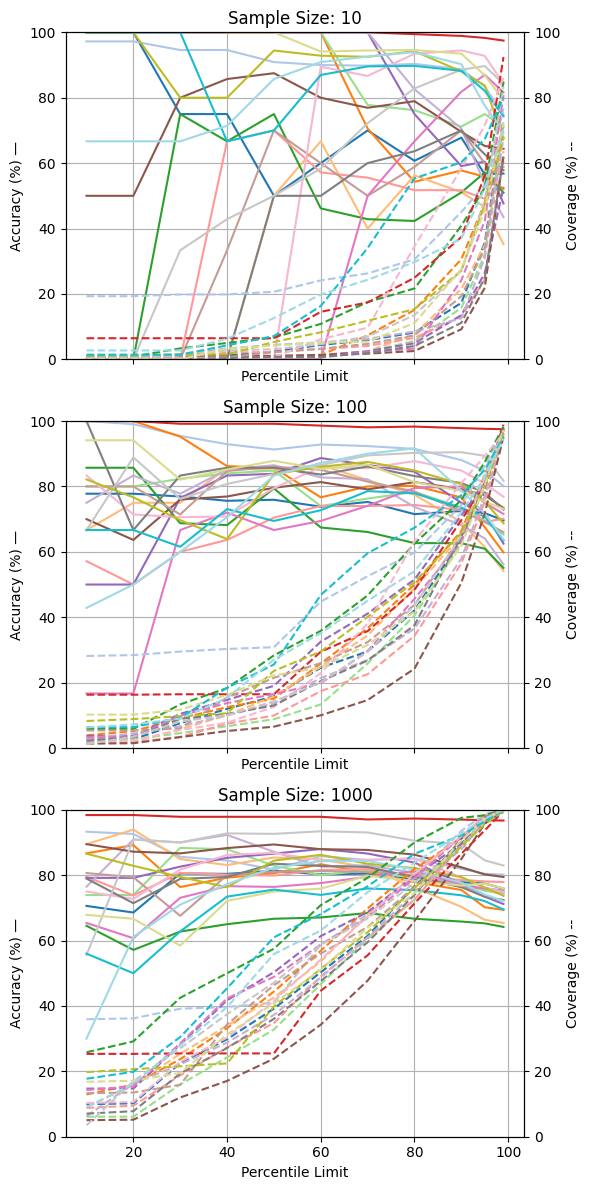

In [16]:
coverage_results_embeddings_cosine_limits_per_class, accuracy_results_embeddings_cosine_limits_per_class = extract_results_limits_per_class(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, class_limits_embeddings_cosine)
plot_results_limits_per_class(coverage_results_embeddings_cosine_limits_per_class, accuracy_results_embeddings_cosine_limits_per_class, samples, percentiles)

In [17]:
train_test_splits = [
    (np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]]), df_split.iloc[0][2]),
    (np.concatenate([df_split.iloc[1][0], df_split.iloc[1][1]]), df_split.iloc[1][2]),
    (np.concatenate([df_split.iloc[2][0], df_split.iloc[2][1]]), df_split.iloc[2][2]),
    (np.concatenate([df_split.iloc[3][0], df_split.iloc[3][1]]), df_split.iloc[3][2]),
    (np.concatenate([df_split.iloc[4][0], df_split.iloc[4][1]]), df_split.iloc[4][2])
]

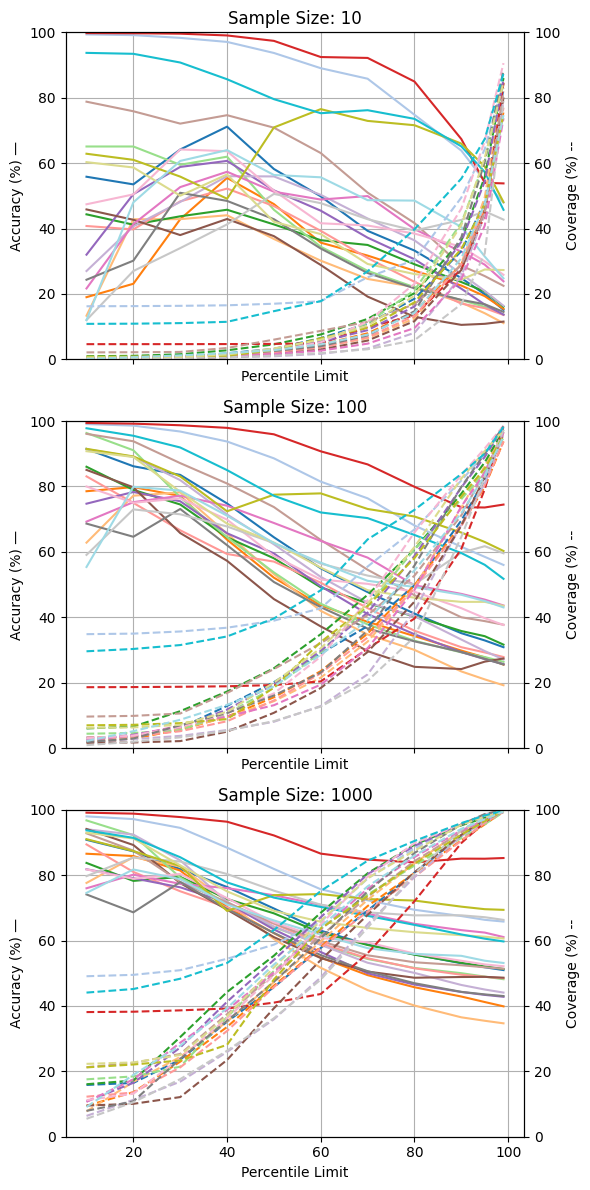

In [18]:
coverage_results_baseline_limits_per_class_splits_avg, accuracy_results_baseline_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_baseline, labels_baseline, train_test_splits, 'euclidean', 'distance', samples, class_limits_baseline)
plot_results_limits_per_class(coverage_results_baseline_limits_per_class_splits_avg, accuracy_results_baseline_limits_per_class_splits_avg, samples, percentiles)

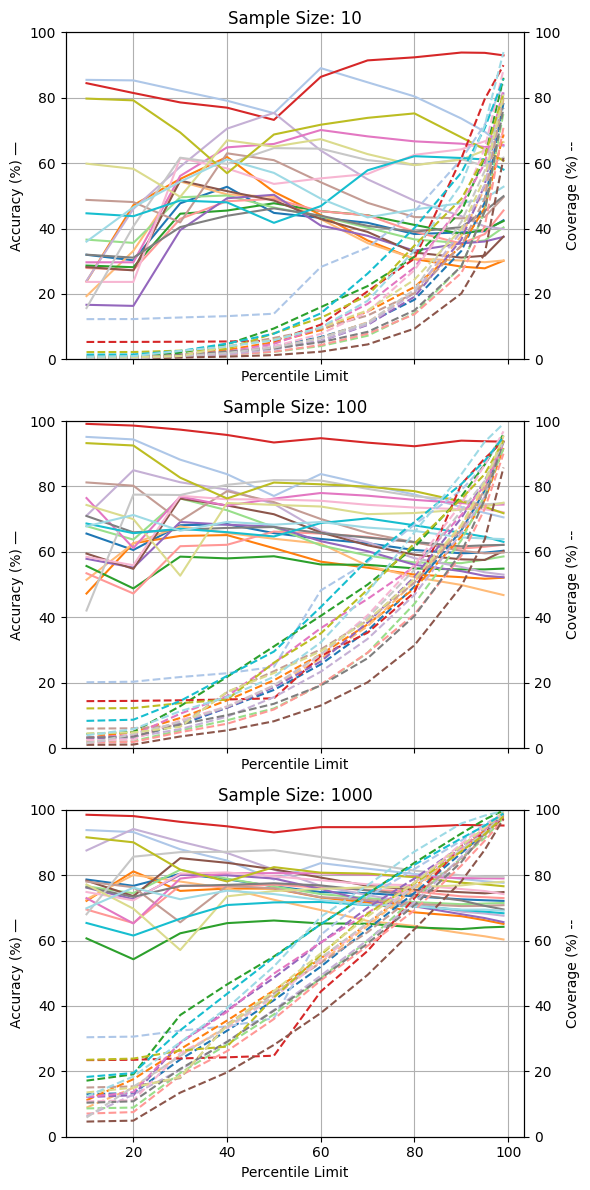

In [19]:
coverage_results_embeddings_limits_per_class_splits_avg, accuracy_results_embeddings_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_embeddings, labels_embeddings, train_test_splits, 'euclidean', 'distance', samples, class_limits_embeddings)
plot_results_limits_per_class(coverage_results_embeddings_limits_per_class_splits_avg, accuracy_results_embeddings_limits_per_class_splits_avg, samples, percentiles)

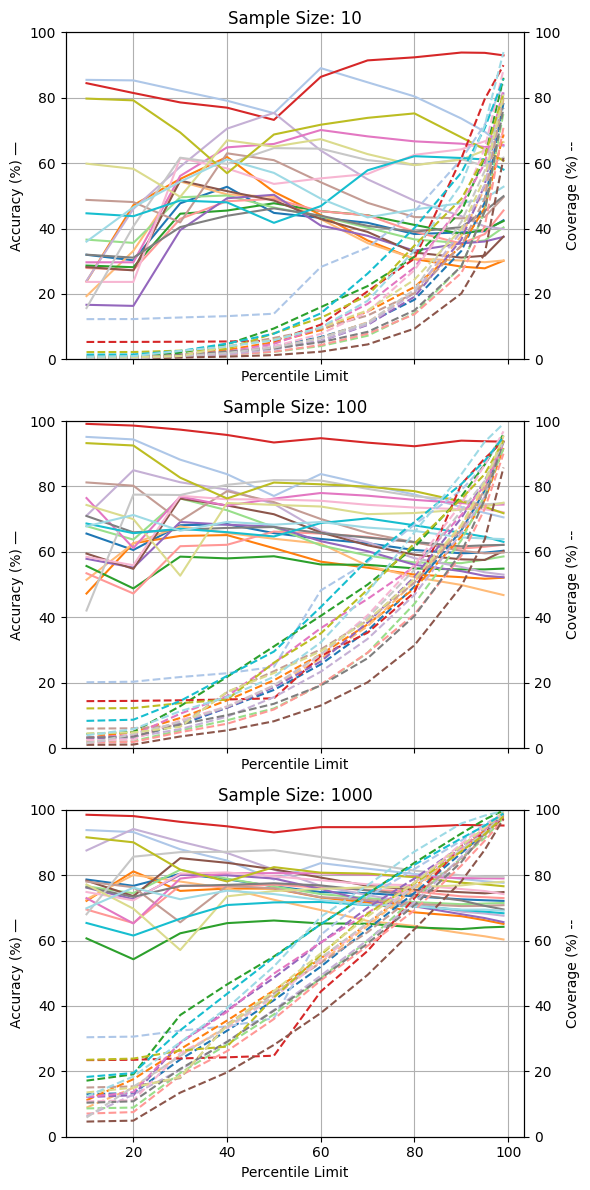

In [20]:
coverage_results_embeddings_cosine_limits_per_class_splits_avg, accuracy_results_embeddings_cosine_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_embeddings, labels_embeddings, train_test_splits, 'euclidean', 'distance', samples, class_limits_embeddings)
plot_results_limits_per_class(coverage_results_embeddings_limits_per_class_splits_avg, accuracy_results_embeddings_limits_per_class_splits_avg, samples, percentiles)